### Exploring the annotated data.


In [1]:
from datasets import load_dataset
import pandas as pd

# can infer the generic loader script this easily
# needs force_redownload to avoid loading incorrect cached stuff
ds = load_dataset("json", data_dir="./data/annotated/", download_mode="force_redownload")
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/19622 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions'],
        num_rows: 19622
    })
})

In [6]:
# in development
from annotate import try_shader
# TODO: make async for multithreading?
def run_test(ex):
    # print(ex)
    for rp in ex["Shader"]["renderpass"]:
        if rp["type"] == "image":
            image_code = rp["code"]
    if not image_code:
        return {"wgpu-test": "untested"}

    res = try_shader(shader_data=ex, image_code=image_code)
    return {"wgpu-test" :res}
# hangs on 344
# raw_ds = raw_ds.map(run_test, num_proc=1, batched=False)

In [2]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv (gated?)
# maybe this instead: https://huggingface.co/datasets/bigcode/the-stack/blob/main/licenses.json
# seems to be the one they actually use: https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt 

import requests
permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
permissive_list = [l.lower() for l in permissive_list]

print(len(permissive_list))


824


In [3]:

print(ds["train"].unique("license"))
# filter permissive licenses
ds["train"].filter(lambda x: x["license"].lower() in permissive_list) #what about those AND and OR classifications?

['CC-BY-NC-SA-3.0', 'cc-by-nc-sa-3.0', 'bsd-new', 'mit', 'cc-by-4.0', 'proprietary-license', 'cc-by-nc-nd-3.0', 'bsd-simplified', 'cc0-1.0', 'unknown-license-reference', 'public-domain', 'apache-2.0', 'cc-by-nc-sa-4.0', 'agpl-3.0', 'cc-by-sa-3.0', 'cc-by-3.0', 'cc-by-sa-2.5', 'cc-by-sa-4.0', 'cc-by-sa-4.0 WITH generic-exception', 'cc-by-3.0 AND mit', 'cc-by-nc-sa-2.0', 'cc-by-nc-sa-3.0 AND proprietary-license', 'wtfpl-2.0', 'gpl-3.0', 'cc-by-4.0 OR cc-by-3.0', 'beerware', 'gpl-3.0-plus OR cc-by-sa-3.0', 'unlicense', 'cc-by-nc-nd-4.0', 'warranty-disclaimer', 'x11', 'gpl-3.0-plus', 'cc-by-nc-4.0', 'cc-by-2.5', 'cc0-1.0 OR openssl-ssleay OR apache-2.0', 'gpl-2.0', 'gpl-2.0-plus', 'cc-by-nc-3.0', 'gpl-1.0-plus', 'artistic-2.0', 'cc-sampling-plus-1.0']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions'],
    num_rows: 660
})

In [4]:
# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions'],
    num_rows: 0
})

<Axes: title={'center': 'license'}, xlabel='date'>

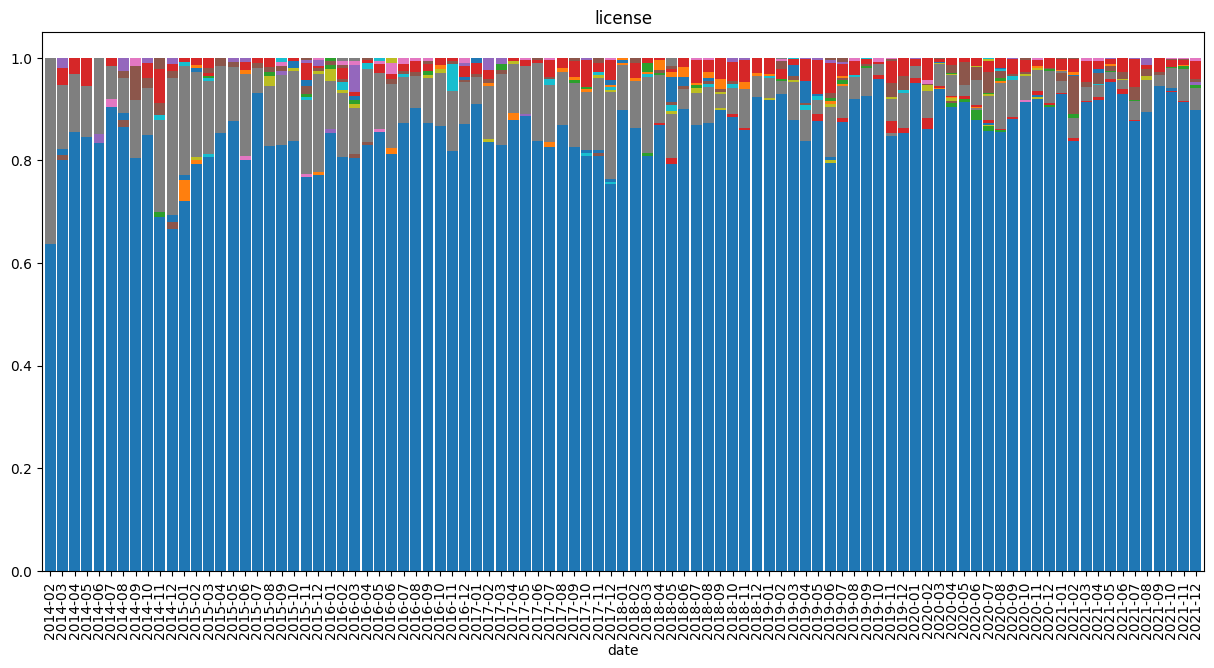

In [15]:
def plot_per_month(column, streched=False, **kwargs):
    feature_df = df["date"].groupby([df["date"].dt.to_period("M"), df[column]]).count().unstack()
    if streched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)
    
plot_per_month("license", True, legend=False)

<Axes: title={'center': 'published'}, xlabel='date'>

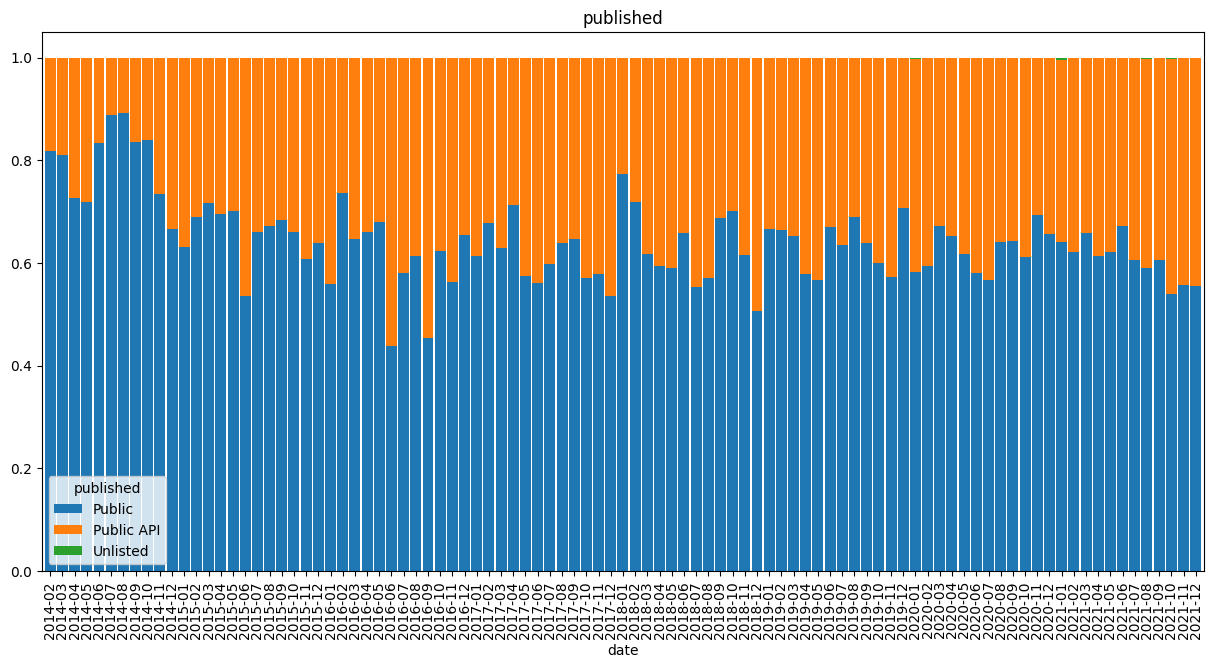

In [17]:
plot_per_month("published", True)

In [20]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

count    19622.000000
mean         8.108450
std         10.439794
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        358.000000
Name: num_functions, dtype: float64

In [21]:
# these cases might be parsing failures? seem to always use macros inside functions or something.
# some use no functions but Main(){...} which seems to work in glsl but not viable for our dataset
from annotate import PARSER
print(PARSER.parse(bytes(df["image_code"][5090],encoding="utf-8")).root_node.has_error)
df.loc[df["num_functions"] == 0]

False


,id,name,author,description,tags,likes,viewed,published,date,time_retrieved,...,buffer_c_inputs,buffer_d_code,buffer_d_inputs,cube_a_code,cube_a_inputs,thumbnail,access,license,functions,num_functions
62,Md23DV,GLSL 2D Tutorials,vug,28 tutorials on writing pixel shaders at Shade...,[tutorial],581,48910,Public,2014-03-08 20:58:49,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/Md23DV...,shaders20k,CC-BY-NC-SA-3.0,[],0
4809,MsSyzW,2D Worley and Cell Noise,TinyTexel,left: 1 - worley\nmiddle: f2^2 - f1^2\nright: ...,"[voronoi, noise, worley]",12,348,Public,2017-04-01 18:38:57,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/MsSyzW...,shaders20k,CC-BY-NC-SA-3.0,[],0
5090,XtySDz,Shadertoy 튜토리얼 한글번역,ho4040,Korean version of https://www.shadertoy.com/vi...,"[tutorial, korean]",7,1040,Public API,2017-05-26 03:06:13,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/XtySDz...,shaders20k,CC-BY-NC-SA-3.0,[],0
5626,4lfczB,Sphere over lake,Nowado,Any description,[sphere],6,444,Public API,2017-09-14 10:06:26,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/4lfczB...,shaders20k,CC-BY-NC-SA-3.0,[],0
5743,XlfcD4,dizzy,sgoal,dizzy,[dizzy],0,66,Public,2017-09-07 04:35:57,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/XlfcD4...,shaders20k,CC-BY-NC-SA-3.0,[],0
5746,XlfyRj,Dancing Star,SunLuke,dance,[huehe],2,116,Public,2017-09-14 12:56:59,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/XlfyRj...,shaders20k,CC-BY-NC-SA-3.0,[],0
8489,llGfW3,rolling triangle tiling (310 ch),FabriceNeyret2,"Funnily, drawing all triangles makes [url]http...","[2d, geometry, gif, short, reproductions]",9,493,Public API,2018-12-07 21:29:36,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/llGfW3...,shaders20k,CC-BY-NC-SA-3.0,[],0
9948,wtX3zB,Almost My First Shader,dr2,See the source...,"[raymarch, landscape, flight, car]",10,602,Public API,2019-05-01 09:54:07,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/wtX3zB...,shaders20k,cc-by-nc-sa-3.0,[],0
11273,WsGGWy,Move in circle ( tutorial ),Kiltun,A simple shader of a circle moving on a ring.\...,"[tutorial, circle, ring, move, moveincircle]",1,172,Public,2019-10-11 16:30:36,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/WsGGWy...,shaders20k,CC-BY-NC-SA-3.0,[],0
15144,WdyyDR,Great Ideas in Graphics Demo,sjobalia,Demo for Great Ideas in Graphics,[demo],1,98,Public,2020-10-12 22:55:41,2021-10-01,...,[],,[],,[],https://www.shadertoy.com/media/shaders/WdyyDR...,shaders20k,CC-BY-NC-SA-3.0,[],0


In [23]:
# TODO: refactor into a generator because I dislike the current shape. but figure out how batching and threadding works then?
# part of the filter.py or prepare.py script that will be done soon.
def split_functions(batch):
    # per function fields
    comments, headers, docstrings, bodies = [],[],[],[]
    # per document fields
    full_code, funcs, ids = [],[],[]
    for code, func_bytes, shader_id in zip(batch["image_code"], batch["functions"], batch["id"]):
        row_code = bytes(code,encoding="utf-8")
        for start_comment, start_header, end_header, end_docstring, end_function in func_bytes:
            comments.append(row_code[start_comment:start_header].decode(encoding="utf-8")),
            headers.append(row_code[start_header:end_header].decode(encoding="utf-8")),
            docstrings.append(row_code[end_header:end_docstring].decode(encoding="utf-8")),
            bodies.append(row_code[end_docstring:end_function].decode(encoding="utf-8")),
            full_code.append(row_code.decode(encoding="utf-8")),
            funcs.append((start_comment, start_header, end_header, end_docstring, end_function))
            ids.append(shader_id)
    return {
            "comment": comments,
            "header": headers,
            "docstring": docstrings,
            "body": bodies,
            "full_code": full_code,
            "func_bytes": funcs,
            "id": ids,
            }

func_ds = ds.map(split_functions, batched=True, remove_columns=ds["train"].column_names)
func_ds

Map:   0%|          | 0/19622 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes'],
        num_rows: 159104
    })
})

In [24]:
func_df = func_ds["train"].to_pandas()
func_df.head() 

,id,comment,header,docstring,body,full_code,func_bytes
0,4dB3DV,,vec3 mod289(vec3 x) {,,\n return x - floor(x * (1.0 / 289.0)) * 289....,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[1, 1, 22, 22, 71]"
1,4dB3DV,,vec2 mod289(vec2 x) {,,\n return x - floor(x * (1.0 / 289.0)) * 289....,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[73, 73, 94, 94, 143]"
2,4dB3DV,,vec4 mod289(vec4 x) {,,\n return x - floor(x * (1.0 / 289.0)) * 289....,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[145, 145, 166, 166, 215]"
3,4dB3DV,,vec4 permute(vec4 x) {,,\n return mod289(((x*34.0)+1.0)*x);\n},\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[217, 217, 239, 239, 279]"
4,4dB3DV,,vec3 permute(vec3 x) {,,\n return mod289(((x*34.0)+1.0)*x);\n},\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[281, 281, 303, 303, 340]"


In [25]:
func_df["has_comment"] = func_df["comment"] != ""
func_df["has_docstring"] = func_df["docstring"] != ""
func_df["model_ctx"] = func_df["comment"] + func_df["header"] + func_df["comment"]
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(func_df["has_comment"], func_df["has_docstring"], margins=True)
print(f"functions with context = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

functions with context = 47102


has_docstring,False,True,All
has_comment,,,
False,112002,8214,120216
True,34632,4256,38888
All,146634,12470,159104


In [26]:
# FINDING: only about half the comments are unique.
# some frequent comment looks like a template maybe? should investigate
print(func_df["comment"].nunique())
func_df["comment"].value_counts(sort=True, ascending=False).head(10)

22552


comment
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                120216
//--------------------------------------------------------------------------\n                                                                                                                                                                                                                                                                                                                                                                                                           

In [27]:
# FINDING = only about a third of function-headers are unique?
# it's expect to have one mainImage function per renderpass... but they are just whitesapce variable here - maybe we skip them in general
print(func_df["header"].nunique())
func_df["header"].value_counts(sort=True, ascending=False).head(10)

64002


header
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    12740
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      1304
void mainImage(out vec4 fragColor, in vec2 fragCoord) {         981
void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{        658
void mainImage( out vec4 fragColor, in vec2 fragCoord ){        548
float sdBox( vec3 p, vec3 b )\n{                                515
float smin( float a, float b, float k )\n{                      352
vec3 ShowScene (vec3 ro, vec3 rd)\n{                            340
void mainImage (out vec4 fragColor, in vec2 fragCoord)\n{       338
float ObjRay (vec3 ro, vec3 rd)\n{                              321
Name: count, dtype: int64

In [28]:
# looks like some are not exact or might even use the common pass to bypass this
func_df["header"].str.startswith("void mainImage").sum()

19507

In [29]:
# half the docstrings aren't unique?
# most common one is the shadertoy.com/new default for the main function
print(func_df["docstring"].nunique())
func_df["docstring"].value_counts(sort=True, ascending=False).head(10)

6461


docstring
                                                        146634
\n    // Normalized pixel coordinates (from 0 to 1)       1893
\n  // n must be normalized                                117
\n    // Based on gluLookAt man page                       112
\n    // c must be normalized                               95
\n    // Normalized pixel coordinates (from -1 to 1)        62
\n    // filter kernel                                      38
\n    // Add scaled noises                                  37
\n     // camera movement\t                                 35
\n    // preserve shape                                     33
Name: count, dtype: int64

In [30]:
# proposed model_ctx takes all of them in normal order (doens't filter out the naked functions)
print(func_df["model_ctx"].nunique())
func_df["model_ctx"].value_counts(sort=True, ascending=False).head(10)

75357


model_ctx
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    11708
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      1110
void mainImage(out vec4 fragColor, in vec2 fragCoord) {         908
void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{        577
void mainImage( out vec4 fragColor, in vec2 fragCoord ){        489
float sdBox( vec3 p, vec3 b )\n{                                363
vec3 ShowScene (vec3 ro, vec3 rd)\n{                            338
void mainImage (out vec4 fragColor, in vec2 fragCoord)\n{       335
float ObjRay (vec3 ro, vec3 rd)\n{                              320
vec3 ObjNf (vec3 p)\n{                                          318
Name: count, dtype: int64